In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
def load_images_from_folder(X_train_names):
    images = []
    for filename in X_train_names:
        img = plt.imread(filename)
        if img is not None:
            images.append(img)
    return images

def load_data_from_folder(folder_name):
    driving_log = pd.DataFrame.from_csv('./' + folder_name + '/driving_log.csv', index_col=None)
    driving_log.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle', 'Break', 'Speed']
    
    X_train_center = ["./" + folder_name + "/" + x for x in driving_log['Center Image'].values.tolist()]
    X_train_center = np.asarray(load_images_from_folder(X_train_center))

    X_train_left = ["./" + folder_name + "/" + x[1:] for x in driving_log['Left Image'].values.tolist()]
    X_train_left = np.asarray(load_images_from_folder(X_train_left))

    X_train_right = ["./" + folder_name + "/" + x[1:] for x in driving_log['Right Image'].values.tolist()]
    X_train_right = np.asarray(load_images_from_folder(X_train_right))

    X_train = np.concatenate((X_train_center, X_train_left, X_train_right), axis=0)

    y_train = driving_log['Steering Angle'].values.tolist()

    y_train_center = y_train
    y_train_left = [x + 0.25 for x in y_train]
    y_train_right = [x - 0.25 for x in y_train]
    
    y_train = np.asarray(y_train_center + y_train_left + y_train_right)
    
    return X_train, y_train

In [3]:
X_train_udacity, y_train_udacity = load_data_from_folder('udacity_data')

In [4]:
X_train_bc, y_train_bc = load_data_from_folder('bc_data')

In [5]:
X_train, y_train = np.concatenate((X_train_udacity, X_train_bc), axis=0), np.concatenate((y_train_udacity, y_train_bc), axis=0)

In [6]:
del X_train_bc
del y_train_bc

In [7]:
print(X_train.shape)
print(y_train.shape)

(128214, 160, 320, 3)
(128214,)


In [ ]:
import pickle

with open('X_train_pca_crop_normalized.pickle', 'wb') as handle:
    pickle.dump(X_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_train.pickle', 'wb') as handle:
    pickle.dump(y_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
import pickle

with open('X_train_pca_crop_normalized.pickle', 'rb') as handle:
    X_train = pickle.load(handle)
    
with open('y_train.pickle', 'rb') as handle:
    y_train = pickle.load(handle)

In [ ]:
from sklearn.decomposition import PCA

def pca_gray_single_image(image):
    imshape = image.shape
    temp = image.reshape(imshape[0] * imshape[1], 3)

    pca = PCA(n_components=1, whiten=True)
    pca.fit(temp)
    
    temp2 = image.reshape(imshape[0] * imshape[1], 3)
    temp2 = pca.transform(temp2)
    temp2 = temp2.reshape(imshape[0], imshape[1])

    return temp2
    
def crop_single_image(image):
    return image[70:][:][:-20][:]

def crop_sky_and_front_cover(image_data):
    return np.apply_along_axis(crop_single_image, axis=1, arr=image_data)

def normalize(image_data):
    max_val = 255
    min_val = 0
    a = -0.5
    b = 0.5
    
    return a + ((image_data - min_val) * (b - a)) / (max_val - min_val)

def preprocess(image_data):
    if len(image_data.shape) == 4:
        # Batch process
        image_data_pca = []
    
        for image in image_data:
            image_data_pca.append(pca_gray_single_image(image))
        
        image_data_pca = np.asarray(image_data_pca)
        
        cropped = crop_sky_and_front_cover(image_data_pca)
    
    elif len(image_data.shape) == 3:
        image_data_pca = pca_gray_single_image(image_data)
        cropped =  crop_single_image(image_data_pca)
    
    else:
        raise TypeError("Wrong image shape!")
    
    # Normalize data
    normalized = normalize(cropped)
    
    return normalized

In [ ]:
import random

def batch_generator(features, labels, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 70, 320, 1))
    batch_labels = np.zeros((batch_size,),)
    
    while 1:
        for i in range(batch_size):
            #choose random index in features
            index = random.randint(0, len(features) - 1)
            batch_features[i] = np.expand_dims(preprocess(features[index]), axis=2)
            batch_labels[i] = labels[index]
            
        yield batch_features, batch_labels

In [ ]:
# X_train_reshape = []

# for image in X_train:
#     X_train_reshape.append(np.expand_dims(image, axis=2))

# X_train = np.asarray(X_train_reshape)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# test = X_train[0]
# print(test.shape)
# temp = test.reshape(test.shape[0], test.shape[1])
# print(temp.shape)

# back = np.expand_dims(temp, axis=2)
# print(back.shape)

# temp = back
# temp = test.reshape(test.shape[0], test.shape[1])
# print(temp.shape)

In [ ]:
# from sklearn.utils import shuffle

# X_train, y_train = shuffle(X_train, y_train, random_state=13)

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU, LeakyReLU

conv_drop = 0.5
fc_drop = 0.5

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(70, 320, 1)))
model.add(Convolution2D(32, 3, 3))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(conv_drop))
model.add(ELU())

model.add(Convolution2D(64, 3, 3))
model.add(Convolution2D(64, 3, 3))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(conv_drop))
model.add(ELU())

model.add(Convolution2D(128, 3, 3))
model.add(Convolution2D(128, 3, 3))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(conv_drop))
model.add(ELU())

model.add(Flatten())

model.add(Dense(512))
model.add(Dropout(fc_drop))
model.add(ELU())

model.add(Dense(64))
model.add(Dropout(fc_drop))
model.add(ELU())

model.add(Dense(16))
model.add(Dropout(fc_drop))
model.add(LeakyReLU())

model.add(Dense(1))

In [14]:
# from keras.models import Sequential
# from keras.layers.core import Dense, Activation, Flatten, Dropout
# from keras.layers.convolutional import Convolution2D
# from keras.layers.pooling import MaxPooling2D
# from keras.layers.advanced_activations import ELU, LeakyReLU

# # Hyperparameters
# batch_size = 32
# EPOCH = 20

# fc_drop = 0.5

# model = Sequential()
# model.add(Convolution2D(24, 5, 5, input_shape=(160, 320, 3)))
# model.add(MaxPooling2D((2, 2)))
# # model.add(Activation('relu'))
# # model.add(LeakyReLU())
# model.add(ELU())

# model.add(Convolution2D(36, 5, 5))
# model.add(MaxPooling2D((2, 2)))
# # model.add(Dropout(0.5))
# # model.add(Activation('relu'))
# # model.add(LeakyReLU())
# model.add(ELU())

# model.add(Convolution2D(48, 5, 5))
# model.add(MaxPooling2D((2, 2)))
# # model.add(Dropout(0.5))
# # model.add(Activation('relu'))
# # model.add(LeakyReLU())
# model.add(ELU())

# model.add(Convolution2D(64, 3, 3))
# model.add(MaxPooling2D((2, 2)))
# # model.add(Dropout(0.5))
# # model.add(Activation('relu'))
# # model.add(LeakyReLU())
# model.add(ELU())

# model.add(Convolution2D(64, 3, 3))
# model.add(MaxPooling2D((2, 2)))
# # model.add(Dropout(0.5))
# # model.add(Activation('relu'))
# # model.add(LeakyReLU())
# model.add(ELU())

# model.add(Flatten())

# model.add(Dense(1164))
# model.add(Dropout(fc_drop))
# # model.add(Activation('relu'))
# # model.add(LeakyReLU())
# model.add(ELU())

# model.add(Dense(100))
# model.add(Dropout(fc_drop))
# # model.add(Activation('relu'))
# # model.add(LeakyReLU())
# model.add(ELU())

# model.add(Dense(50))
# model.add(Dropout(fc_drop))
# # model.add(Activation('relu'))
# # model.add(LeakyReLU())
# model.add(ELU())

# model.add(Dense(10))
# model.add(Dropout(fc_drop))
# # model.add(Activation('relu'))
# # model.add(LeakyReLU())
# model.add(ELU())

# model.add(Dense(1))

In [5]:
# import json
# from keras.models import model_from_json

# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json.loads(json_file.read())
# json_file.close()
# model = model_from_json(loaded_model_json)
# # load weights into new model
# model.load_weights("model.h5")
# print("Loaded model from disk")

Using TensorFlow backend.


Loaded model from disk


In [33]:
from keras.optimizers import Adam

# Hyperparameters
batch_size = 64
EPOCH = 5

# initialize generators
training_samples_gen = batch_generator(X_train, y_train, batch_size=128)
validation_samples_gen = batch_generator(X_train_udacity, y_train_udacity, batch_size=128)

# train model
model.fit_generator(
    my_samples_gen,
    samples_per_epoch=128*188, nb_epoch=EPOCHS,
    validation_data=u_samples_gen,
    nb_val_samples=24000,
    callbacks=[early_stop, checkpoint]
)
adam = Adam(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer=adam)
# history = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=EPOCH, validation_split=0.2)
history = model.fit_generator(batch_generator(X_train, y_train, 5), samples_per_epoch=10000, nb_epoch=10, validation_data=validation_samples_gen, nb_val_samples=24000,)

Epoch 1/3
10/10 [==============================] - 14s - loss: 0.8260     
Epoch 2/3
10/10 [==============================] - 0s - loss: 1.5759     
Epoch 3/3
10/10 [==============================] - 0s - loss: 0.2297     


In [13]:
# score = model.evaluate(X_test, y_test, batch_size=batch_size)
# print('Test score (MSE): ', score)
# predictions = model.predict(X_test)
# print('predictions: ', predictions[:32])
# print('actual: ', y_test[:32])

dict_keys(['loss', 'val_loss'])


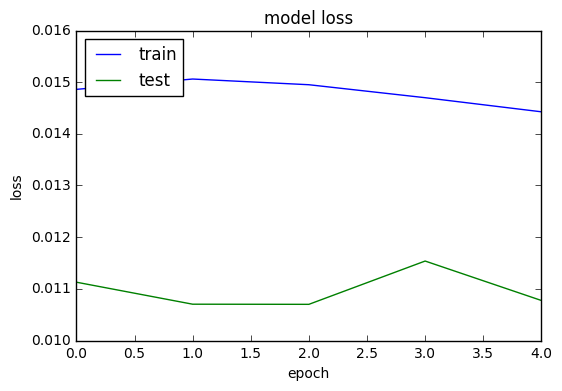

In [7]:
# list all data in history
print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
import json
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)

In [9]:
model.save_weights('model.h5')

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 68, 318, 32)   320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 66, 316, 32)   9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 33, 158, 32)   0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 33, 158, 32)   0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
# First Turn and the black tunnel
ft_driving_log = pd.DataFrame.from_csv('./first_turn_data/driving_log.csv', index_col=None)
ft_driving_log.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle', 'Break', 'Speed']

In [3]:
ft_driving_log.shape

(904, 7)

In [4]:
X_train_names_ft = ft_driving_log['Center Image'].values.tolist()

In [5]:
def load_images_from_folder(X_train_names):
    images = []
    for filename in X_train_names:
        img = plt.imread(filename)
        if img is not None:
            images.append(img)
    return images

In [9]:
X_train_ft = np.asarray(load_images_from_folder(X_train_names_ft))

In [10]:
y_train_ft = ft_driving_log['Steering Angle'].values

In [11]:
def normalize_rgb(image_data):
    max_val = 255
    min_val = 0
    a = -0.5
    b = 0.5
    
    return a + ((image_data - min_val) * (b - a)) / (max_val - min_val)

X_train_ft = normalize_rgb(X_train_ft)

In [12]:
from sklearn.model_selection import train_test_split

X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_train_ft, y_train_ft, test_size=0.25, random_state=13)

In [13]:
# MLP for Pima Indians Dataset serialize to JSON and HDF5
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

# load json and create model
json_file = open('model.json', 'r')
ft_model_json = json.loads(json_file.read())
json_file.close()
ft_model = model_from_json(ft_model_json)
# load weights into new model
ft_model.load_weights("model.h5")
print("Loaded model from disk")

Using TensorFlow backend.


Loaded model from disk


In [14]:
from keras.optimizers import SGD, RMSprop, Adam

# sgd = SGD(lr=0.001, decay=0.1, momentum=0.9, nesterov=True)
# rms = RMSprop(lr=0.0001)

adam = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)

ft_model.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_squared_error"])
history = ft_model.fit(X_train_ft, y_train_ft, batch_size=16, nb_epoch=5, validation_split=0.2)
# history = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=10, verbose=1, validation_split=0.3)

Train on 542 samples, validate on 136 samples
Epoch 1/5
542/542 [==============================] - 3s - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0154 - val_mean_squared_error: 0.0154
Epoch 2/5
542/542 [==============================] - 2s - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 3/5
542/542 [==============================] - 2s - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 4/5
542/542 [==============================] - 2s - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 5/5
542/542 [==============================] - 2s - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0146 - val_mean_squared_error: 0.0146


In [15]:
score = ft_model.evaluate(X_test_ft, y_test_ft, batch_size=16)
print('Test score (MSE): ', score)
predictions = ft_model.predict(X_test_ft)
print('predictions: ', predictions[:32])
print('actual: ', y_test_ft[:32])

226/226 [==============================] - 0s     
Test score (MSE):  [0.018108080655585695, 0.018108080655585695]
predictions:  [[-0.02845112]
 [-0.00991601]
 [ 0.00375535]
 [ 0.01345983]
 [ 0.00874765]
 [ 0.1190468 ]
 [-0.01119138]
 [ 0.17105819]
 [-0.02077729]
 [-0.00374757]
 [ 0.10398643]
 [-0.01840652]
 [-0.00287744]
 [-0.00335364]
 [-0.00456724]
 [-0.0263858 ]
 [ 0.00104263]
 [ 0.09320861]
 [-0.00472504]
 [-0.00257948]
 [-0.03707062]
 [ 0.01123323]
 [ 0.00802351]
 [-0.00030356]
 [-0.0600503 ]
 [ 0.02151077]
 [ 0.00234454]
 [-0.00259226]
 [ 0.00840481]
 [-0.03599612]
 [ 0.0102901 ]
 [ 0.04407694]]
actual:  [-0.09813455 -0.01962936  0.         -0.08693992  0.          0.3074819   0.
  0.3224199   0.          0.          0.2700831  -0.09439113  0.          0.
  0.         -0.2140385   0.          0.3336502  -0.1056214   0.         -0.1878701
  0.          0.          0.         -0.1168161   0.2700831   0.1093649
 -0.06447928  0.          0.          0.          0.3224199 ]


dict_keys(['loss', 'val_loss'])


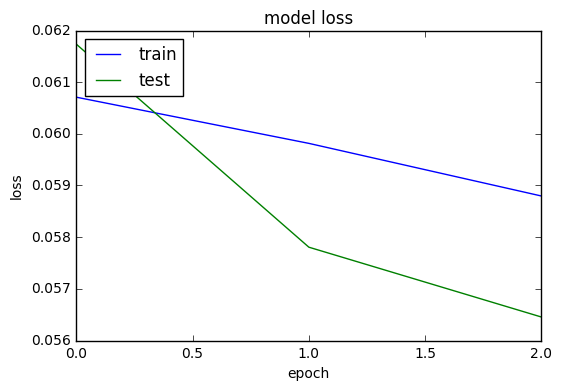

In [43]:
# list all data in history
print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# with open('model_ft.json', 'w') as outfile:
#     json.dump(ft_model.to_json(), outfile)
    
# ft_model.save_weights('model_ft.h5')

In [44]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Second Turn
st_driving_log = pd.DataFrame.from_csv('./second_turn_data/driving_log.csv', index_col=None)
st_driving_log.columns = ['Center Image', 'Left Image', 'Right Image', 'Steering Angle', 'Throttle', 'Break', 'Speed']

st_driving_log.shape

(12254, 7)

In [2]:
def load_images_from_folder(X_train_names):
    images = []
    for filename in X_train_names:
        img = plt.imread(filename)
        if img is not None:
            images.append(img)
    return images

X_train_names_st = st_driving_log['Center Image'].values.tolist()

X_train_st = np.asarray(load_images_from_folder(X_train_names_st))
y_train_st = st_driving_log['Steering Angle'].values

In [3]:
from sklearn.utils import shuffle

def normalize_rgb(image_data):
    max_val = 255
    min_val = 0
    a = -0.5
    b = 0.5
    
    return a + ((image_data - min_val) * (b - a)) / (max_val - min_val)

X_train_st = normalize_rgb(X_train_st)

X_train_st, y_train_st = shuffle(X_train_st, y_train_st, random_state=13)

In [4]:
# MLP for Pima Indians Dataset serialize to JSON and HDF5
import json
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

# load json and create model
json_file = open('model_ft.json', 'r')
st_model_json = json.loads(json_file.read())
json_file.close()
st_model = model_from_json(st_model_json)
# load weights into new model
st_model.load_weights("model_ft.h5")
print("Loaded model from disk")

Using TensorFlow backend.


Loaded model from disk


In [5]:
from keras.optimizers import SGD, RMSprop, Adam

# sgd = SGD(lr=0.001, decay=0.1, momentum=0.9, nesterov=True)
# rms = RMSprop(lr=0.0001)

adam = Adam(lr=0.0010, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)

st_model.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_squared_error"])
history = st_model.fit(X_train_st, y_train_st, batch_size=16, nb_epoch=5, validation_split=0.15)
# history = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=10, verbose=1, validation_split=0.3)

Train on 10415 samples, validate on 1839 samples
Epoch 1/5
10415/10415 [==============================] - 39s - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 2/5
10415/10415 [==============================] - 37s - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 3/5
10415/10415 [==============================] - 37s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 4/5
10415/10415 [==============================] - 37s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 5/5
10415/10415 [==============================] - 37s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0048 - val_mean_squared_error: 0.0048


In [6]:
with open('model_st.json', 'w') as outfile:
    json.dump(st_model.to_json(), outfile)
    
st_model.save_weights('model_st.h5')